# Deep Learning for Engineers


## First Some Helpers

In [1]:

def print_row(cols, max_length=20):
    col_width = max_length
    print("".join(str(word).ljust(col_width) for word in cols))


## Load the data

In [2]:
def load_data(pickle_file):
    import pickle

    try:
        with open(pickle_file, 'rb') as f:
            return pickle.load(f)
    except Exception as e:
        print('Unable to load data from', pickle_file, ':', e)
        raise

data = load_data('partial_notMNIST.pickle')
train_dataset = data['train_dataset']
train_labels = data['train_labels']
test_dataset = data['test_dataset']
test_labels = data['test_labels']
valid_dataset = data['valid_dataset']
valid_labels = data['valid_labels']

### Show some data

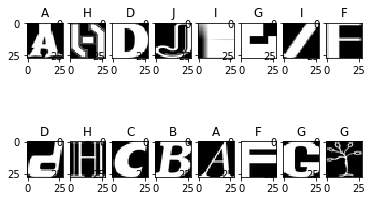

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import random

def one_hot_to_char(one_hot):
    return "ABCDEFGHIJKLMOPQRSTUVWXYZ"[one_hot]

n = 16
rows = 2
for i in range(1,1+n):
    image_to_show = random.randint(0,len(train_dataset))
    
    plt.subplot(rows,n/rows,i)
    plt.imshow(train_dataset[image_to_show], cmap="gray")
    plt.title(one_hot_to_char(train_labels[image_to_show]))

## Summary

In [4]:
print("Train: ", train_dataset.shape)
print("Test: ", test_dataset.shape)
print("Valid: ", valid_dataset.shape)

Train:  (10000, 28, 28)
Test:  (1000, 28, 28)
Valid:  (2000, 28, 28)


## Demo 0: Random Classifier

In [5]:
import numpy as np

def accuracy(predictions, labels):
  return (np.sum(np.array(predictions) == np.array(labels))
          / len(predictions))

def evaluate_classifier(classifier):  
    # Train
    classifier.fit(train_dataset, train_labels)
    
    # Evaluate
    predictions = classifier.predict(test_dataset)

    print("Test accuracy: %s" % accuracy(predictions, test_labels))

In [6]:
class RandomClassifier:
    import random
    
    def fit(self, test_data, test_labels):
        self.seen_labels = set(test_labels)
    
    def predict(self, data):
        return [random.sample(self.seen_labels,1)[0] for i in data]

In [7]:
evaluate_classifier(RandomClassifier())

Test accuracy: 0.108


## Demo 1: Tensor Flow



In [8]:
import numpy as np
import tensorflow as tf

graph = tf.Graph()
with graph.as_default():
    A = tf.constant(np.array([1,2,3,4,5]))
    B = tf.constant(np.array([1,2,3,4,5]))
    R = A + B


In [9]:
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    res = session.run([R])
    print(res)
    

[array([ 2,  4,  6,  8, 10])]


## Demo 3: Logistic Regression using TensorFlow

Let's implement the logistic regression using tensor flow.

In [10]:
import numpy as np

image_size = 28
num_labels = 10

def to_one_hot(labels):
    return (np.arange(num_labels) == labels[:,None]).astype(np.float32)

def from_one_hot(labels):
    return np.argmax(labels,1)

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
  labels = to_one_hot(labels)
  return dataset, labels


In [11]:

class TensorLogisticRegression:
    def __init__(self):
        self.num_steps = 1000
    
    def softmax_output(self, weights, biases, data):
        logits = tf.matmul(data, weights) + biases
        # Predict!
        prediction = tf.nn.softmax(logits)
        return prediction, logits
    
    def fit(self, train_dataset, train_labels):
        train_dataset, train_labels = reformat(train_dataset, train_labels)
        
        with graph.as_default():
          # Load the Data
          tf_train_dataset = tf.constant(train_dataset)
          tf_train_labels = tf.constant(train_labels)
          tf_valid_dataset = tf.constant(valid_dataset)
          tf_test_dataset = tf.constant(test_dataset)

          # Linear Model
          weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
          biases = tf.Variable(tf.zeros([num_labels]))

          prediction, logits = self.softmax_output(weights, biases, tf_train_dataset)  
            
          loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))

          # Optimizer.
          optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
          
        
        with tf.Session(graph=graph) as session:
          print_row(['Step', 'Loss', 'A-Train'])
          tf.global_variables_initializer().run()
          for step in range(self.num_steps):
            w, b, _, l, predictions = session.run([weights, biases, optimizer, loss, prediction])
            if (step % 100 == 0):
              train_acc = accuracy(from_one_hot(predictions), from_one_hot(train_labels))                  

              print_row([step, l, train_acc])
                
          self.weights = w
          self.biases = b
            
    def predict(self, data):
        data,_ = reformat(data, np.arange(10))
        
        with graph.as_default():
            weights = tf.constant(self.weights)
            biases = tf.constant(self.biases)
            tfdata = tf.constant(data)
            prediction, logits = self.softmax_output(weights, biases, tfdata)
            
        with tf.Session(graph=graph) as session:
            tf.global_variables_initializer().run()
            predictions, logits = session.run([prediction, logits])
            return from_one_hot(predictions)


In [12]:
evaluate_classifier(TensorLogisticRegression())

Step                Loss                A-Train             
0                   14.499              0.1323              
100                 2.30174             0.7179              
200                 1.85821             0.7506              
300                 1.61308             0.7635              
400                 1.44739             0.7738              
500                 1.32386             0.7832              
600                 1.22653             0.7869              
700                 1.14732             0.7909              
800                 1.08143             0.7957              
900                 1.02559             0.7995              
Test accuracy: 0.817


## Demo 4: Stochastic Gradient Descent


In [13]:
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)

train_subset = 128

def accuracy(predictions, labels):
  return (np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

graph = tf.Graph()
with graph.as_default():
  # Load the Data
  tf_train_dataset = tf.constant(train_dataset[:train_subset, :])
  tf_train_labels = tf.constant(train_labels[:train_subset])
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Linear Model
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predict!
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [14]:
num_steps = 3000
batch_size = 128

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print_row(['Step', 'Loss', 'Acc-Train', 'Acc-Valid'])
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    
    if (step % 500 == 0):
      train_acc = accuracy(predictions, batch_labels)
      valid_acc = accuracy(valid_prediction.eval(), valid_labels)
        
      print_row([step, l, train_acc, valid_acc])
  print("Test accuracy: %.4f%%" % accuracy(test_prediction.eval(), test_labels))

Step                Loss                Acc-Train           Acc-Valid           
0                   16.6153             0.109375            0.1155              
500                 0.428728            0.875               0.7455              
1000                1.53497             0.6796875           0.757               
1500                1.27728             0.7578125           0.76                
2000                0.929354            0.765625            0.7655              
2500                0.868899            0.796875            0.759               
Test accuracy: 0.8280%


## Demo 4: First Neural Network

In [15]:
batch_size = 128
num_relu = 1024

graph = tf.Graph()
with graph.as_default():
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights_1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_relu]))
  biases_1 = tf.Variable(tf.zeros([num_relu]))
  
  hidden_input = tf.matmul(tf_train_dataset, weights_1) + biases_1
  hidden_output = tf.nn.relu(hidden_input)

  weights_2 = tf.Variable(tf.truncated_normal([num_relu, num_labels]))
  biases_2 = tf.Variable(tf.zeros([num_labels]))

  # Training computation.
  logits = tf.matmul(hidden_output, weights_2) + biases_2

  # Loss to optimize
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset,weights_1)+biases_1), weights_2) + biases_2)
  test_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset,weights_1)+biases_1), weights_2) + biases_2)


In [16]:
num_steps = 4001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print_row(['Step', 'Loss', 'Acc-Train', 'Acc-Valid'])
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    
    if (step % 500 == 0):
      test_acc = accuracy(predictions, batch_labels)
      valid_acc = accuracy(valid_prediction.eval(), valid_labels)
        
      print_row([step, l, test_acc, valid_acc])
  print("Test accuracy: %.4f" % accuracy(test_prediction.eval(), test_labels))

Step                Loss                Acc-Train           Acc-Valid           
0                   327.996             0.0859375           0.404               
500                 0.305806            0.984375            0.8145              
1000                0.021833            0.9921875           0.832               
1500                5.48303e-05         1.0                 0.8285              
2000                1.29803e-05         1.0                 0.8305              
2500                0.0                 1.0                 0.829               
3000                7.46887e-07         1.0                 0.8295              
3500                2.42143e-08         1.0                 0.829               
4000                9.87695e-06         1.0                 0.827               
Test accuracy: 0.8800


## Demo 5: Regularization



In [17]:
batch_size = 256
num_relu = 1024

graph = tf.Graph()
with graph.as_default():

  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights_1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_relu]))
  biases_1 = tf.Variable(tf.zeros([num_relu]))
  
  hidden_input = tf.matmul(tf_train_dataset, weights_1) + biases_1
  hidden_output = tf.nn.relu(hidden_input)
  regularized_output_1 = tf.nn.dropout(hidden_output, 0.5)

  weights_2 = tf.Variable(tf.truncated_normal([num_relu, num_labels]))
  biases_2 = tf.Variable(tf.zeros([num_labels]))

  # Training computation.
  logits = tf.matmul(regularized_output_1, weights_2) + biases_2

  # Loss to optimize
  beta = tf.constant(0.001)
  l2_w1 = beta * tf.nn.l2_loss(weights_1)
  l2_w2 = beta * tf.nn.l2_loss(weights_2)
  logits = tf.matmul(hidden_output, weights_2) + biases_2 
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels)) + l2_w1 + l2_w2
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset,weights_1)+biases_1), weights_2) + biases_2)
  test_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset,weights_1)+biases_1), weights_2) + biases_2)


In [18]:
num_steps = 4000

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print_row(['Step', 'Loss', 'Acc-Train', 'Acc-Valid'])
  for step in range(num_steps):
    # Pick Minibatch
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    
    if step % 1000 == 0:
      test_acc = accuracy(predictions, batch_labels)
      valid_acc = accuracy(valid_prediction.eval(), valid_labels)
        
      print_row([step, l, test_acc, valid_acc])
  print("Test accuracy: %.4f%%" % accuracy(test_prediction.eval(), test_labels))

Step                Loss                Acc-Train           Acc-Valid           
0                   610.83              0.140625            0.251               
1000                114.785             1.0                 0.809               
2000                42.226              1.0                 0.813               
3000                15.5832             1.0                 0.8305              
Test accuracy: 0.8980%


# Demo 6: Convolutional Networks

In [19]:
image_size = 28
num_labels = 10
num_channels = 1 

import numpy as np

data = load_data('partial_notMNIST.pickle')
train_dataset = data['train_dataset']
train_labels = data['train_labels']
test_dataset = data['test_dataset']
test_labels = data['test_labels']
valid_dataset = data['valid_dataset']
valid_labels = data['valid_labels']

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (10000, 28, 28, 1) (10000, 10)
Validation set (2000, 28, 28, 1) (2000, 10)
Test set (1000, 28, 28, 1) (1000, 10)


In [20]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal([image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))
    
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [21]:
num_steps = 10001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print_row(['Step', 'Loss', 'Acc-Train', 'Acc-Valid'])
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % (num_steps // 10) == 0):
      test_acc = accuracy(predictions, batch_labels)
      valid_acc = accuracy(valid_prediction.eval(), valid_labels)
      print_row([step, l, test_acc, valid_acc])   
  print('Test accuracy: %.4f%%' % accuracy(test_prediction.eval(), test_labels))

Step                Loss                Acc-Train           Acc-Valid           
0                   3.5968              0.0625              0.1605              
1000                0.80587             0.625               0.828               
2000                0.245534            0.9375              0.8465              
3000                0.336098            0.9375              0.852               
4000                0.319397            0.875               0.853               
5000                0.701432            0.8125              0.852               
6000                0.0823003           1.0                 0.8525              
7000                0.0349664           1.0                 0.8535              
8000                0.0623412           1.0                 0.85                
9000                0.00409627          1.0                 0.8565              
10000               0.0646515           0.9375              0.841               
Test accuracy: 0.8990%
